<a href="https://colab.research.google.com/github/ederson-hub/Dio-Machine-Learning/blob/main/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 12017, done.
remote: Counting objects: 100% (2219/2219), done.
remote: Compressing objects: 100% (1056/1056), done.
remote: Total 12017 (delta 1251), reused 1925 (delta 1116), pack-reused 9798 (from 1)
Receiving objects: 100% (12017/12017), 47.13 MiB | 45.02 MiB/s, done.
Resolving deltas: 100% (8289/8289), done.


In [ ]:
!pip install tensorflow

In [8]:
!pip install opencv-python

In [11]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.3/477.3 kB 8.5 MB/s eta 0:00:00


In [12]:
from IPython import display
from PIL import Image
import numpy as np
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

## Load the COCO index mapping


In [13]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image


--2025-08-06 21:34:21--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1451380 (1.4M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.38M  8.48MB/s    in 0.2s    

2025-08-06 21:34:21 (8.48 MB/s) - ‘test.jpg’ saved [1451380/1451380]



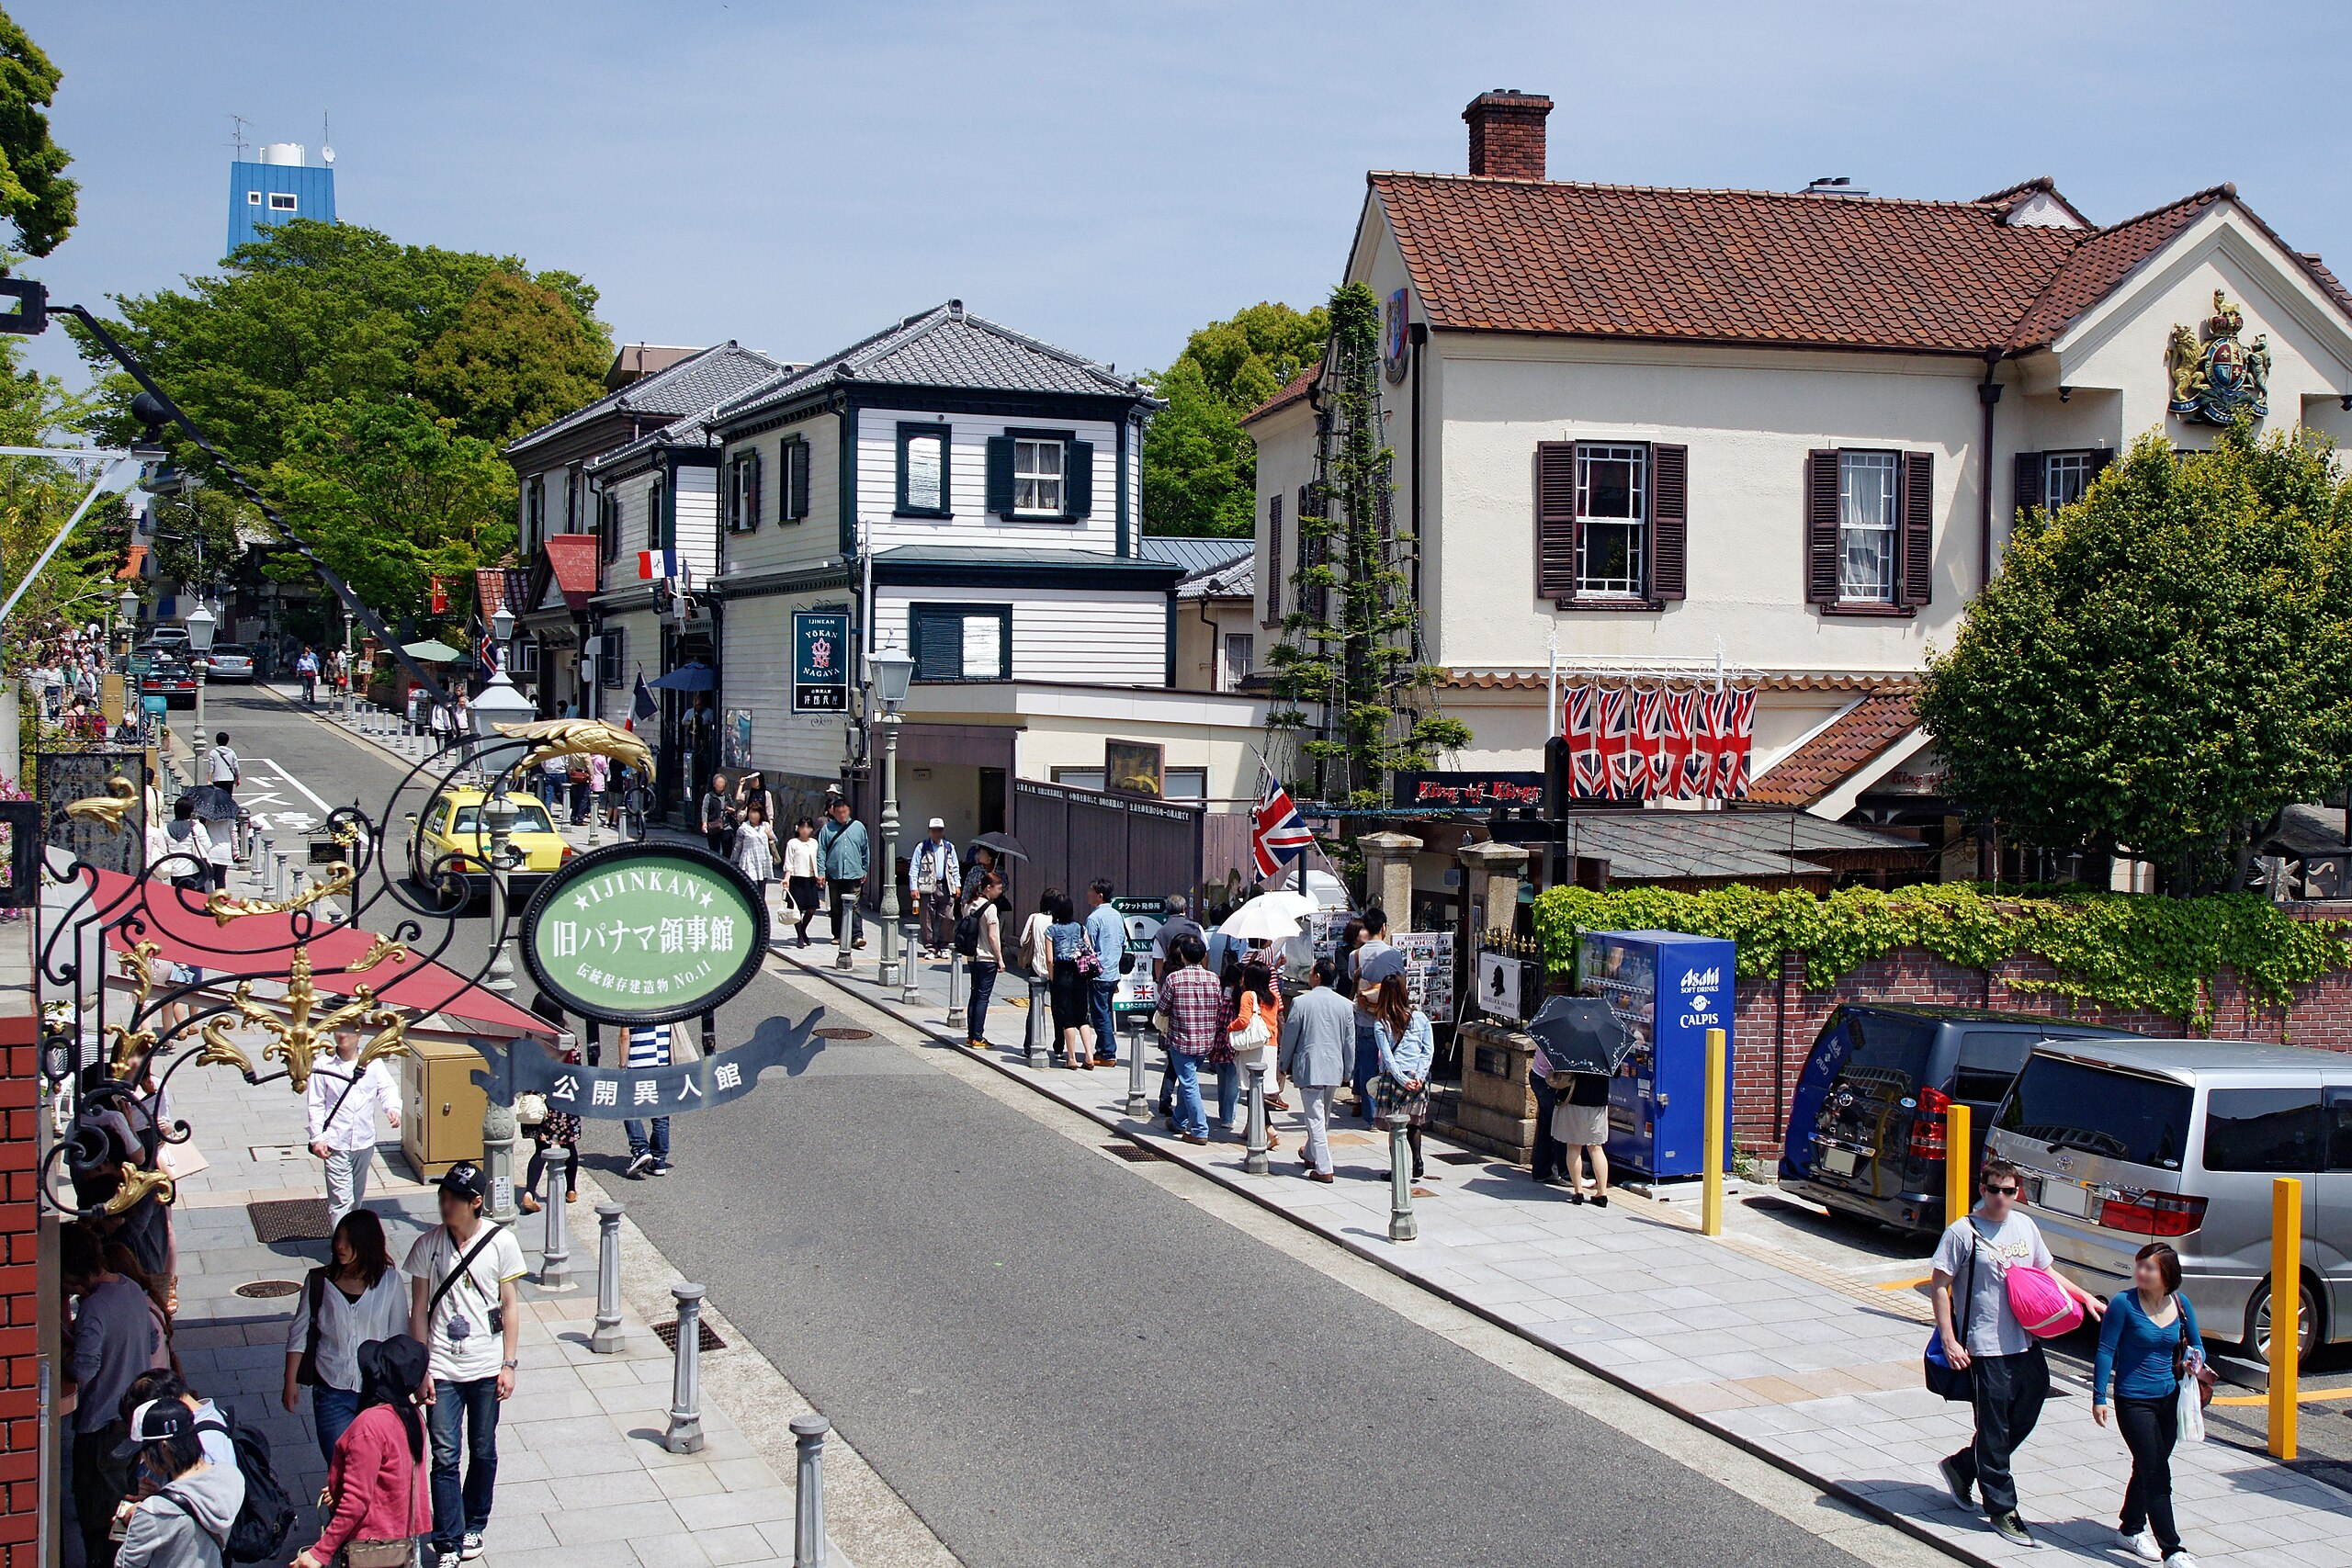

In [14]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session


In [21]:
use_tpu = False
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)
  print('TPU devices:')
else:
  pass

# Load the pretrained model


In [18]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.load(saved_model_dir)

## Perform instance segmentation and retrieve the predictions



In [ ]:
image_tensor = tf.constant(np_image_string)
image_tensor = tf.constant(np_image_string)

try:
    loaded_model = _
except NameError:
    print("Could not find the loaded model variable. Please ensure the model loading cell (6lCL-ZcwaJbA) was executed and the loaded model is in a variable accessible here (e.g., named `loaded_model`).")
    raise
try:
    results = loaded_model.signatures['serving_default'](tf.constant(np_image_string))
except KeyError:
     print("Could not find 'serving_default' signature. Inspect loaded_model.signatures to find the correct signature name.")
     raise
except ValueError as e:
    print(f"Error calling the model. Check the input tensor shape and type. Error: {e}")
    print(f"Expected input signature: {loaded_model.signatures['serving_default'].structured_input_signature}")
    print(f"Provided input tensor: {image_tensor}")
    raise
try:
    num_detections = results['num_detections'].numpy().squeeze().astype(np.int32)
    if 'width' not in locals() or 'height' not in locals():
        print("Image width and height variables not found. Ensure the cell loading the image was executed.")
        pass
    detection_boxes_normalized = results['detection_boxes'].numpy().squeeze()
    if detection_boxes_normalized.ndim == 2 and detection_boxes_normalized.shape[1] == 4:
        detection_boxes = detection_boxes_normalized * np.array([height, width, height, width])
    else:
        print(f"Unexpected shape for detection_boxes: {detection_boxes_normalized.shape}. Expected [N, 4].")
        detection_boxes = detection_boxes_normalized # Use as is, likely will cause issues later


    detection_classes = results['detection_classes'].numpy().squeeze().astype(np.int32)
    detection_scores = results['detection_scores'].numpy().squeeze()
    instance_masks = results['detection_masks'].numpy().squeeze() # Masks are likely [N, height, width]

except KeyError as e:
    print(f"Could not find expected key in model output results dictionary: {e}")
    print("Available keys in results dictionary:")
    if isinstance(results, dict):
        print(results.keys())
    else:
        print("Model output is not a dictionary.")
    raise
except Exception as e:
    print(f"An error occurred during result extraction: {e}")
    raise

detection_boxes = detection_boxes[0:num_detections]
detection_scores = detection_scores[0:num_detections]
detection_classes = detection_classes[0:num_detections]
instance_masks = instance_masks[0:num_detections]

ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.stack([xmin.squeeze(), ymin.squeeze(), (xmax - xmin).squeeze(), (ymax - ymin).squeeze()], axis=1)

try:
    segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
except Exception as e:
    print(f"Error generating segmentations: {e}")
    print("Ensure coco_metric.generate_segmentation_from_masks is compatible with the data types and shapes.")
    print(f"instance_masks shape: {instance_masks.shape}, dtype: {instance_masks.dtype}")
    print(f"processed_boxes shape: {processed_boxes.shape}, dtype: {processed_boxes.dtype}")
    print(f"height: {height}, width: {width}")
    raise


## Visualize the detection results


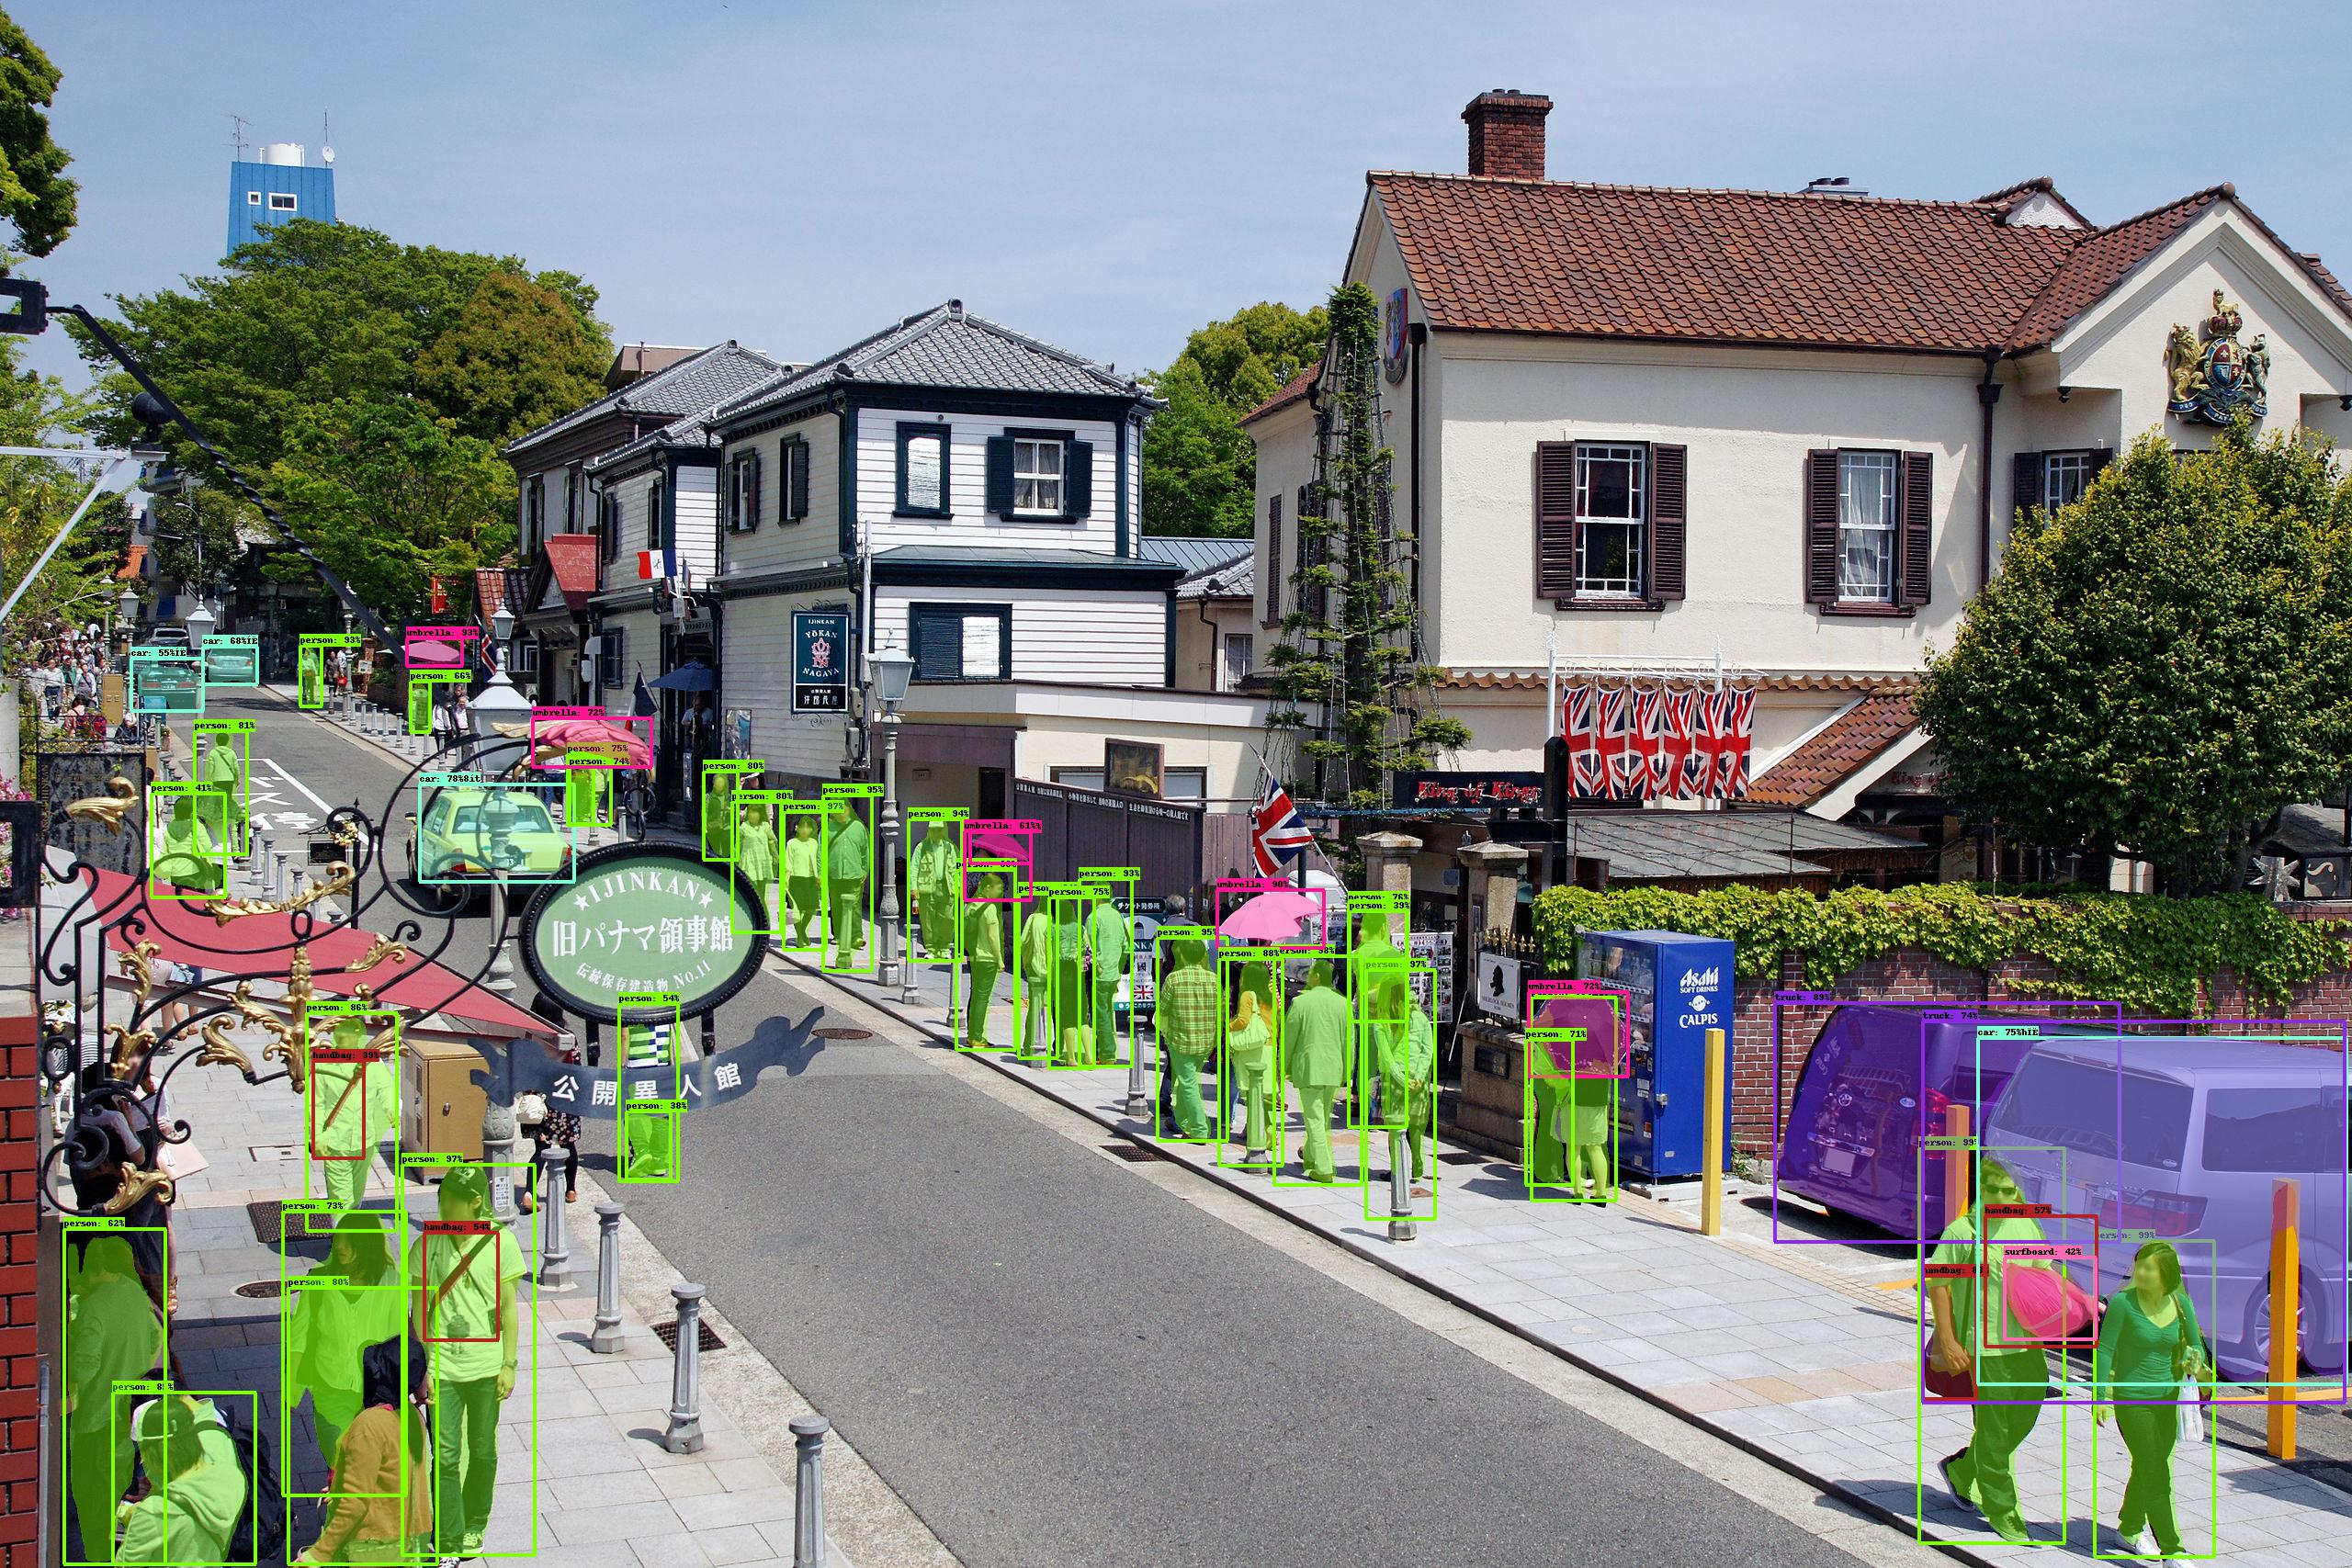

In [ ]:
max_boxes_to_draw = 50
min_score_thresh = 0.1
image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))